# HeatMap baby

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 227
sns.set_style("whitegrid")

In [3]:
enrol= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/enrol_clean.parquet")
demo= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/demo_clean.parquet")
bio= pd.read_parquet("/Users/mrehanansari/Documents/UIDAI/data/parquet/bio_clean.parquet")

In [4]:
enrol.drop(columns= ['Unnamed: 0'], inplace= True)
demo.drop(columns= ['Unnamed: 0'], inplace= True)
bio.drop(columns= ['Unnamed: 0'], inplace= True)

In [6]:
enrol_dist = (
    enrol.groupby(["state", "district"], as_index=False)
         ["total_enrolments"].sum()
)
demo_dist = demo.groupby(["state", "district"], as_index=False)["demo_activity"].sum()
bio_dist  = bio.groupby(["state", "district"], as_index=False)["bio_activity"].sum()

In [8]:
district_df = (
    enrol_dist
    .merge(demo_dist, on=["state", "district"], how="left")
    .merge(bio_dist,  on=["state", "district"], how="left")
    .fillna(0)
)

district_df["total_update_activity"] = (
    district_df["demo_activity"] + district_df["bio_activity"]
)

district_df["update_to_enrolment_ratio"] = (
    district_df["total_update_activity"] /
    district_df["total_enrolments"].replace(0, np.nan)
)

In [9]:
MIN_ACTIVITY = district_df["total_update_activity"].quantile(0.75)

heatmap_df = district_df[
    district_df["total_update_activity"] >= MIN_ACTIVITY
]

In [10]:
pivot = heatmap_df.pivot(
    index="district",
    columns="state",
    values="update_to_enrolment_ratio"
)

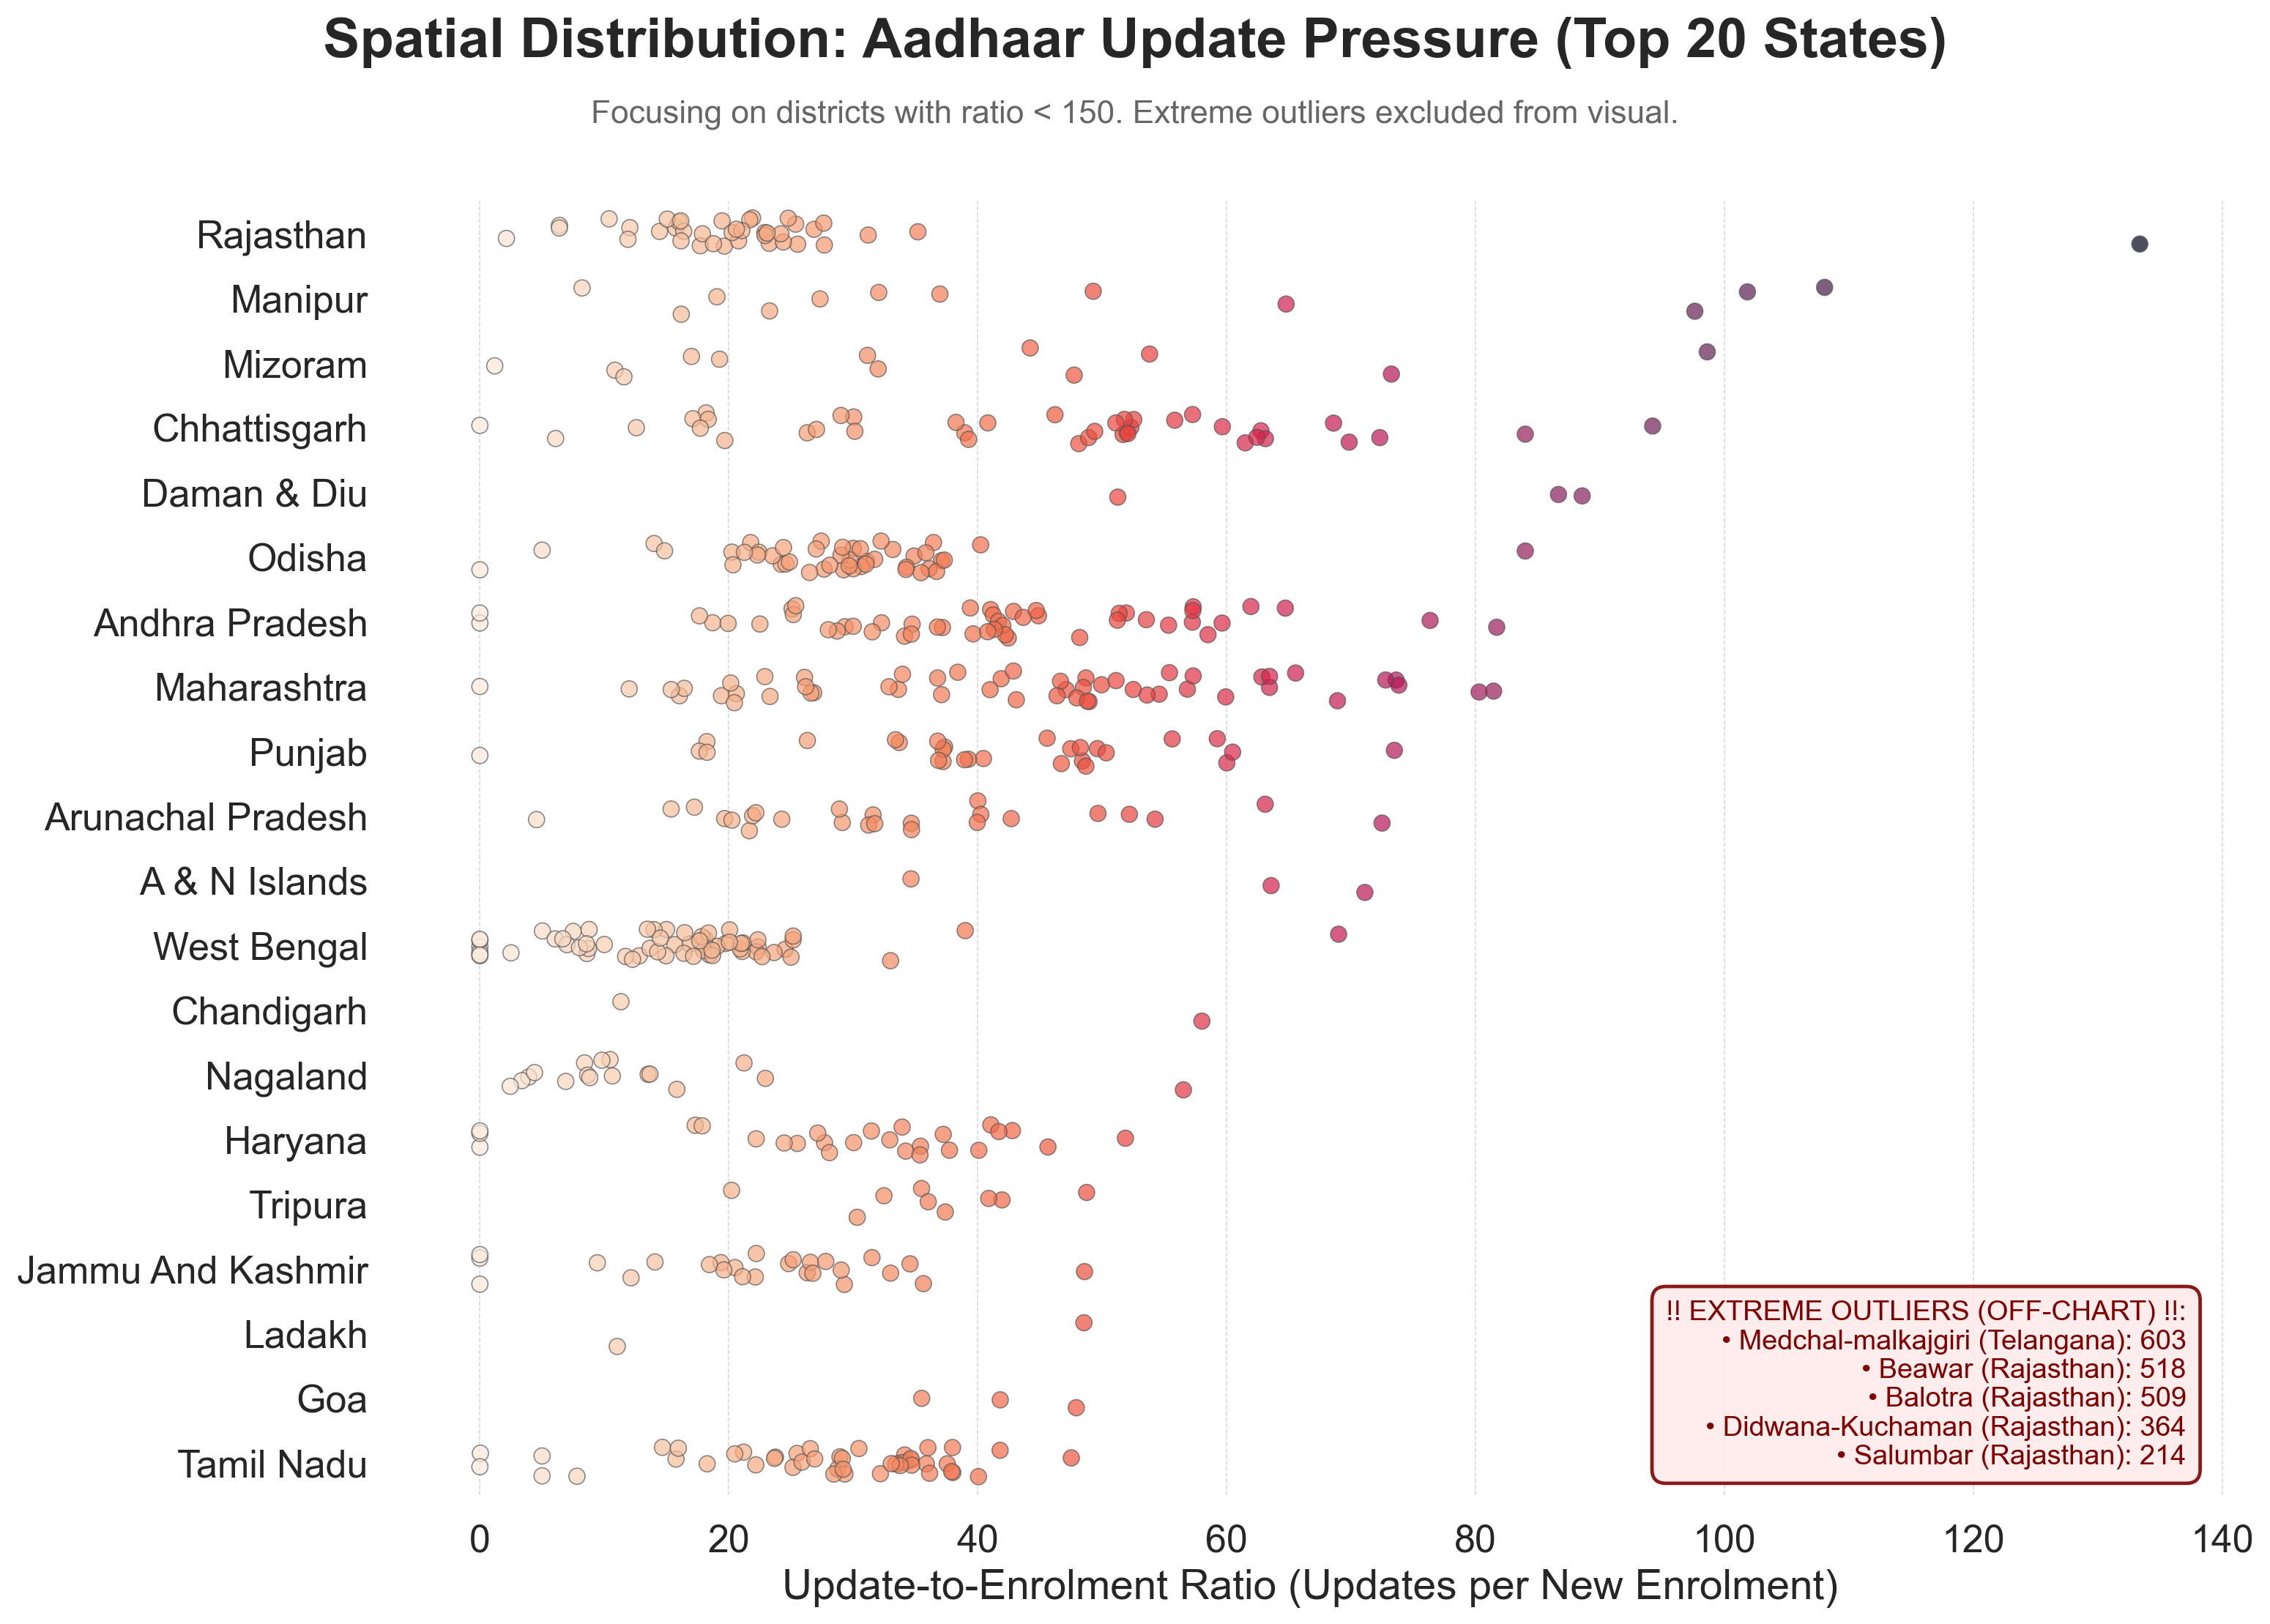

In [22]:
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

# 1. CLEAN DATA (CRITICAL: Do this BEFORE filtering)
plot_data = district_df.copy()

# Fix District Names (e.g., 'Medchal?malkajgiri' -> 'Medchal-Malkajgiri')
plot_data['district'] = plot_data['district'].astype(str).str.replace('?', '-')

# Fix State Names (Title Case, Strip, and Specific Replacements)
plot_data['state'] = plot_data['state'].str.title().str.strip()
plot_data['state'] = plot_data['state'].replace({
    'Westbengal': 'West Bengal',
    'Daman And Diu': 'Daman & Diu', 
    'Dadra And Nagar Haveli': 'Dadra & Nagar Haveli',
    'Andaman And Nicobar Islands': 'A & N Islands'
})

# 2. FILTER OUTLIERS & SELECT TOP STATES
# Identify Outliers (Ratio > 150) to handle separately
outliers = plot_data[plot_data["update_to_enrolment_ratio"] > 150].sort_values("update_to_enrolment_ratio", ascending=False)
normal_data = plot_data[plot_data["update_to_enrolment_ratio"] <= 150]

# Filter: Only show Top 20 States with the highest 'Max' pressure to reduce clutter
top_states_list = normal_data.groupby('state')['update_to_enrolment_ratio'].max().sort_values(ascending=False).head(20).index
filtered_data = normal_data[normal_data['state'].isin(top_states_list)]

# 3. PLOT: HORIZONTAL STRIP PLOT
ax = sns.stripplot(
    data=filtered_data,
    y="state",
    x="update_to_enrolment_ratio",
    hue="update_to_enrolment_ratio",
    palette="rocket_r",
    size=7,
    alpha=0.7,
    jitter=0.25,
    edgecolor="#555555",
    linewidth=0.5,
    order=top_states_list
)

# --- NEW: Vertical Gridlines for Readability ---
ax.grid(True, axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# 4. TITLES
plt.figtext(0.5, 0.96, "Spatial Distribution: Aadhaar Update Pressure (Top 20 States)", 
            fontsize=24, weight='bold', ha='center')

plt.figtext(0.5, 0.92, "Focusing on districts with ratio < 150. Extreme outliers excluded from visual.", 
            fontsize=14, color='#666666', ha='center')

# 5. CUSTOMIZE AXES
plt.ylabel("")
plt.xlabel("Update-to-Enrolment Ratio (Updates per New Enrolment)")

# Remove Legend
if ax.legend_:
    ax.legend_.remove()

# 6. ADD "OUTLIER BOX"
outlier_text = "!! EXTREME OUTLIERS (OFF-CHART) !!:\n" + "\n".join(
    [f"• {row['district']} ({row['state']}): {row['update_to_enrolment_ratio']:.0f}" 
     for _, row in outliers.head(5).iterrows()]
)

plt.text(
    x=0.98, y=0.02, # Bottom Right position
    s=outlier_text,
    transform=ax.transAxes, # Relative to box coordinates
    fontsize=12,
    color="#800000",
    bbox=dict(boxstyle="round,pad=0.5", fc="#ffeaea", ec="#800000", alpha=0.9),
    ha="right",
    va="bottom"
)

# 7. LAYOUT
sns.despine(left=True, bottom=True)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()